#### 6

In [1]:
library(forecast)
library(ggplot2)
library(dplyr)
library(gridExtra)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



In [2]:
# library(doParallel)
library(doMC)
options(cores = 10)
registerDoMC()
require(svMisc)

Loading required package: foreach
Loading required package: iterators
Loading required package: parallel
Loading required package: svMisc

Attaching package: ‘svMisc’

The following object is masked from ‘package:utils’:

    ?



In [3]:
library(data.table)
library(hts)  


Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last



In [4]:
df_eu  <-  read.csv(file="../data_hts/hts_rus_summed.csv", header=TRUE, sep=",", row.names =1 )
# df_eu  <-  df_eu/1000
var_freq  <- 12    
var_start_year  <- 2006      
gdp_agg <- df_eu_sums <-  rowSums(df_eu)
gdp_agg  <- ts(gdp_agg, frequency = var_freq, start = var_start_year) 

In [5]:
var_h  <- 24
var_window  <-  84 - 1
var_topup  <-  -1
var_iter   <- (length(gdp_agg)+var_topup)/var_freq-(var_window+1)/var_freq-2

In [6]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

var_arpdq   <-  c(4,1,1)
var_sarpdq   <-  c(1,1,1)
var_drift   <-  FALSE
var_constant   <-  FALSE

var_char  <-  c(4,2)

In [7]:
df_eu  <-  as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data, characters = var_char)
s  <-  smatrix(y)
# gts_train  <- window(y, start=19, end=46)
# gts_test  <- window(y, start=47, end=54)
# allts <- aggts(gts_train)
# allf <- matrix(, nrow=var_h, ncol=ncol(allts))

In [8]:
l <- ac <- m_top  <- l_test  <-  l_top  <-  list()

df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1
    
    train_start  <- dates[1] 
    train_end  <- dates[2]
    test_start  <- dates[3]
    test_end  <- dates[4]
    
    print(c(train_start, train_end, test_start, test_end))
    
    
    if (i == 0){
        gts_train <- window(y, end=train_end)    
    }
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            gts_train <- window(y, start=dates[5], end=dates[6])
        }else{
            gts_train <- window(y, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        gts_test <- window(y, start=dates[7])
      
    }else{  
     gts_test <- window(y, start=test_start, end=test_end)
          
    }
    
    
    allts <- aggts(gts_train)
    
    ms <-  foreach(j=1:ncol(allts)) %dopar% {
        model  <- tryCatch(        
        Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq,  include.drift = var_drift, include.mean = var_constant, method="ML"), 
            error = function(e) 
#                               {tryCatch( 
                Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq, include.drift = var_drift, include.mean = var_constant, method="CSS") #,
#                          error = function(e)              
#                             auto.arima(msts(allts[,j], seasonal.periods = var_freq))
#                          )}
                        
            )
        
    }
    
     
        
    allf <- matrix(, nrow=var_h, ncol=ncol(allts))
        
    
    for(j in 1:ncol(allts)){  
    allf[,j] <- forecast(ms[[j]], h=var_h)$mean
    
    
    }

    
    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g)
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5, characters = var_char)
        
#     if (i == 4){
#         gts_forecasts_7 <- window(y_f5, start=test_start)}
#     else{
#     gts_forecasts_7 <- window(y_f5, start=test_start, end=test_end)
# #     }

#     if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
#         gts_forecasts_7 <- window(y_f5, start=dates[7])
      
#     }else{  
     gts_forecasts_7 <- window(y_f5, start=dim(y_f5[[1]])[1]-var_h+1)
          
#     }
         
    print(gts_forecasts_7)
    print(gts_test)
            
    
    l[[k]]  <- allf

    ac[[k]]  <-  accuracy.gts(gts_forecasts_7, gts_test)[, 1] 

    progress(i, progress.bar = TRUE)
            
    }

[1]   1  84  85 108


Warning message in predict.Arima(object, n.ahead = h):
“MA part of model is not invertible”

Hierarchical Time Series 
3 Levels 
Number of nodes at each level: 1 80 320 
Total number of series: 401 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -22032.0821   1298.2602   -265.6241   2277.7929  -2413.1074   8793.9433
 [7]  18759.2249  23412.4785  22476.6224  18204.3091  12859.4456   9538.8742
[13] -10759.7092  10467.4087   8682.9322  10118.7197   6643.5189  19050.5013
[19]  29087.8148  33706.2394  32440.1444  27704.0994  22342.5833  19219.2164
Hierarchical Time Series 
3 Levels 
Number of nodes at each level: 1 80 320 
Total number of series: 401 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -21804  -5608 -15157  -9048  -8227   6992  23186  23066  11709  11702
[11]   5839    263 -14727  -1700  -6177  -2526  -5848   6309  23731  19854
[21]  12060  10071    438  -2700
          0%---------25%---------50%---------75%--------100%
Progress: [1]  13 

Warning message in predict.Arima(object, n.ahead = h):
“MA part of model is not invertible”

Hierarchical Time Series 
3 Levels 
Number of nodes at each level: 1 80 320 
Total number of series: 401 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -15438.9791   3897.9431   -527.5547   1447.6338  -1401.2396  10614.4278
 [7]  21599.4719  25145.5674  22548.8179  20010.1476  14146.5346  10750.3689
[13]  -8968.7973   9799.1280   6243.5394   7689.3830   5749.4626  18264.5302
[19]  28787.9324  32394.3719  29788.1983  26906.4048  21133.9949  17894.4734
Hierarchical Time Series 
3 Levels 
Number of nodes at each level: 1 80 320 
Total number of series: 401 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 97 
End = 120 
Frequency = 1 
 [1] -14727  -1700  -6177  -2526  -5848   6309  23731  19854  12060  10071
[11]    438  -2700 -24328 -11496 -13858  -6986  -5066   4880  26123  23705
[21]  18556  14103   4114   8705
[1]  25 108 109 132
Hierarchical Time Series 
3 Levels 
Number of nodes at each

In [9]:
var_acc_metrics  <-  c(1,2,4)
df_acc_test  <- ac[[1]][var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc  <- df_acc_test
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [10]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)

In [11]:
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [12]:
l[[5]][,1]

Time Series:
Start = 1 
End = 24 
Frequency = 1 
 [1] -18465.263 -18013.514 -14147.644 -13017.856  -4875.290  11253.794
 [7]  11989.259   2601.752  -2270.057  -9506.055 -13473.768 -45650.058
[13] -24242.214 -19453.504 -19475.942 -19469.850  -8805.389   3293.581
[19]   5363.691  -5384.058 -11649.020 -17031.936 -24837.424 -55395.973

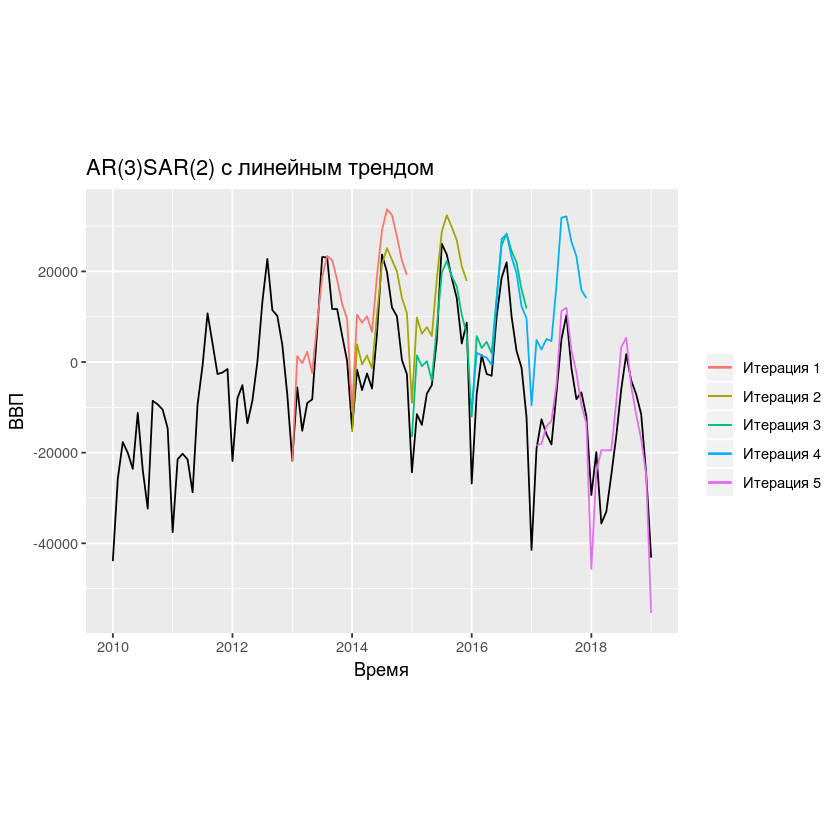

In [13]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

# for (i in 0:(var_iter*var_allornot - var_shift)){
#     k  <-  k+1
#     st_year  <-  var_start_year + i/var_allornot
#     train_start  <- st_year 
#     train_end  <- st_year + 1/var_freq*(var_window)
#     test_start  <- st_year + 1/var_freq*(var_window+1) 
#     test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1

    

for (i in 1:length(l)){
    if (i!=length(l)){
    plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1), series=paste("Итерация" , i, sep=" ") ) 
    }else{
            plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1-var_topup/var_freq), series=paste("Итерация" , i, sep=" ") ) 

        
    }
}

plot_forecasts


In [14]:
df_acc

ME,RMSE,MAPE,Iteration
-9996.484,12107.307,517.00134,1
-9634.948,11328.085,266.04773,13
-7432.306,10395.280,169.54805,25
-17088.910,19493.754,305.81585,37
-1320.083,7306.225,60.55481,50


In [15]:
colMeans(df_acc)

ME       RMSE       MAPE  Iteration 
-9094.5463 12126.1300   263.7936    25.2000

In [16]:
df_mean_acc <- readRDS("df_mean_acc.rds")
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,82.46349,320.0250,12274
3 level,83.34961,319.6023,NA
2 level (state),82.52303,319.5933,NA
2 level (type),81.81728,321.0356,NA
2 level (clusetered),82.25295,317.7805,NA


In [17]:
df_mean_acc[2,3]  <-  colMeans(df_acc)[[2]] 
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,82.46349,320.0250,12274.00
3 level,83.34961,319.6023,12126.13
2 level (state),82.52303,319.5933,NA
2 level (type),81.81728,321.0356,NA
2 level (clusetered),82.25295,317.7805,NA


In [18]:
df_acc

ME,RMSE,MAPE,Iteration
-9996.484,12107.307,517.00134,1
-9634.948,11328.085,266.04773,13
-7432.306,10395.280,169.54805,25
-17088.910,19493.754,305.81585,37
-1320.083,7306.225,60.55481,50


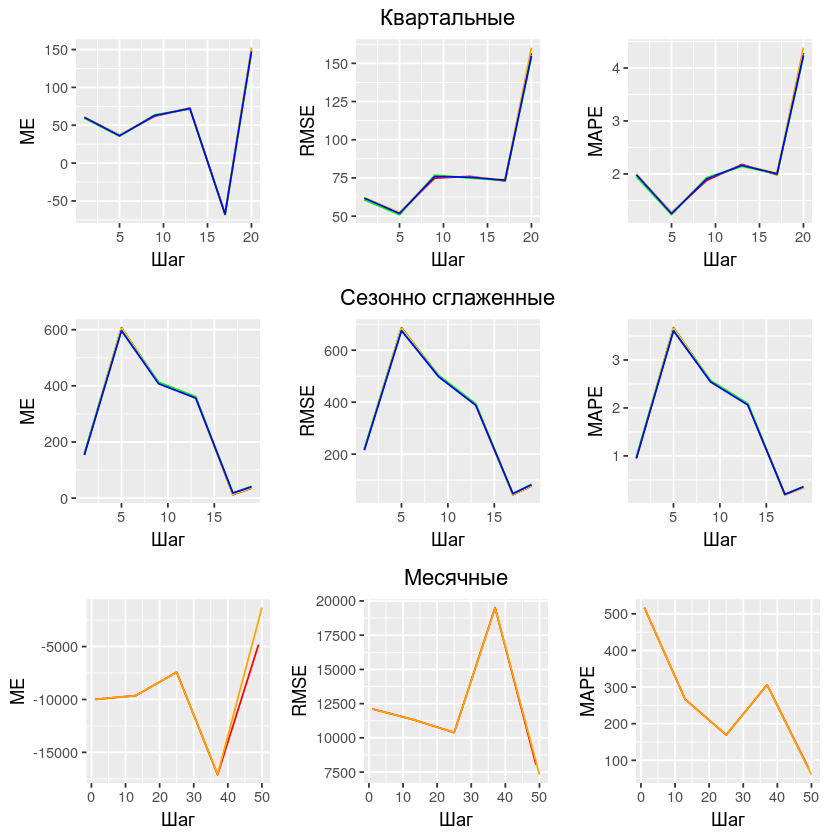

In [19]:
# Basic line plot with points

plots_test_all <- readRDS("plots_test_not_all.rds")

var_col_test  <-  'orange'
# var_col_train  <-  'red'

for (i in 1:3) {
    
    k = i + 6
    
    if  (i==1) {
        
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=ME), colour = var_col_test, data =  df_acc) 
    
        } else if (i==2) { 
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=RMSE), colour = var_col_test, data =  df_acc) 
        } else if (i==3)  {
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=MAPE), colour = var_col_test, data =  df_acc) 
 
    }        
    }

grid.arrange(grobs = plots_test_all, ncol = 3)

#### 2 state

In [20]:
df_eu  <-  read.csv(file="../clustering/hts_rus_summed_state.csv", header=TRUE, sep=",", row.names =1 )
# df_eu  <-  df_eu/1000


In [21]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

In [22]:
df_eu  <-  as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data)
s  <-  smatrix(y)
# gts_train  <- window(y, start=20, end=67)
# gts_test  <- window(y, start=68, end=75)
allts <- aggts(y)
allf <- matrix(, nrow=var_h, ncol=ncol(allts))

Since argument characters are not specified, the default labelling system is used.


In [23]:
l <- ac <- m_top  <- l_test  <-  l_top  <-  list()

df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1
    
    train_start  <- dates[1] 
    train_end  <- dates[2]
    test_start  <- dates[3]
    test_end  <- dates[4]
    
    print(c(train_start, train_end, test_start, test_end))
    
    
    if (i == 0){
        gts_train <- window(y, end=train_end)    
    }
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            gts_train <- window(y, start=dates[5], end=dates[6])
        }else{
            gts_train <- window(y, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        gts_test <- window(y, start=dates[7])
      
    }else{  
     gts_test <- window(y, start=test_start, end=test_end)
          
    }
    
    
    
    allts <- aggts(gts_train)
    
    ms <-  foreach(j=1:ncol(allts)) %dopar% {
        model  <- tryCatch(        
        Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq,  include.drift = var_drift, include.mean = var_constant, method="ML"), 
            error = function(e) 
#                               {tryCatch( 
                Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq, include.drift = var_drift, include.mean = var_constant, method="CSS") #,
#                          error = function(e)              
#                             auto.arima(msts(allts[,j], seasonal.periods = var_freq))
#                          )}
                        
            )
        
    }
    
     
        
    allf <- matrix(, nrow=var_h, ncol=ncol(allts))
        
    
    for(j in 1:ncol(allts)){  
    allf[,j] <- forecast(ms[[j]], h=var_h)$mean
    
    
    }

    
    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g)
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5)
        
#     if (i == 4){
#         gts_forecasts_7 <- window(y_f5, start=test_start)}
#     else{
#     gts_forecasts_7 <- window(y_f5, start=test_start, end=test_end)
# #     }

#     if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
#         gts_forecasts_7 <- window(y_f5, start=dates[7])
      
#     }else{  
     gts_forecasts_7 <- window(y_f5, start=dim(y_f5[[1]])[1]-var_h+1)
          
#     }
         
    print(gts_forecasts_7)
    print(gts_test)
            
    
    l[[k]]  <- allf

    ac[[k]]  <-  accuracy.gts(gts_forecasts_7, gts_test)[, 1] 

    progress(i, progress.bar = TRUE)
            
    }

[1]   1  84  85 108


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 80 
Total number of series: 81 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -22054.354   1301.109   -257.108   2277.552  -2409.199   8793.746
 [7]  18752.057  23413.985  22478.469  18202.940  12864.334   9540.529
[13] -10766.348  10471.466   8682.890  10119.073   6645.376  19049.877
[19]  29090.042  33709.801  32442.556  27708.279  22346.182  19219.754
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 80 
Total number of series: 81 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -21804  -5608 -15157  -9048  -8227   6992  23186  23066  11709  11702
[11]   5839    263 -14727  -1700  -6177  -2526  -5848   6309  23731  19854
[21]  12060  10071    438  -2700
          0%---------25%---------50%---------75%--------100%
Progress: [1]  13  96  97 120


Warning message in predict.Arima(object, n.ahead = h):
“MA part of model is not invertible”Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 80 
Total number of series: 81 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -15442.7204   3913.4069   -511.7242   1453.5094  -1391.3501  10620.1755
 [7]  21598.0685  25154.3844  22557.1696  20013.0352  14159.4758  10760.2319
[13]  -8964.2048   9812.8738   6255.2261   7698.9397   5760.6552  18273.4664
[19]  28795.1362  32404.9435  29798.2019  26914.4811  21146.0684  17905.2047
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 80 
Total number of series: 81 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 97 
End = 120 
Frequency = 1 
 [1] -14727  -1700  -6177  -2526  -5848   6309  23731  19854  12060  10071
[11]    438  -2700 -24328 -11496 -13858  -6986  -5066   4880  26123  23705
[21]  18556  14103   4114   8705
[1]  25 108 109 132


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 80 
Total number of series: 81 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -16545.0960   1468.0816   -916.1333    201.5814  -4029.6426   7857.1696
 [7]  19749.7147  22319.6040  18947.8513  16716.3137  10478.2866   6152.8099
[13] -12012.5915   5754.0455   3127.5425   4462.6801   1993.2298  14340.7662
[19]  25805.4098  28372.3162  24502.7554  21977.2932  16050.6121  11852.9451
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 80 
Total number of series: 81 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 109 
End = 132 
Frequency = 1 
 [1] -24328 -11496 -13858  -6986  -5066   4880  26123  23705  18556  14103
[11]   4114   8705 -26799  -6998   1542  -2629  -3031  10067  18591  22017
[21]  10026   2420  -1256 -12220
|[1]  37 120 121 144


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 80 
Total number of series: 81 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -10661.5921   2034.3998   1400.7270    950.3664   -610.5622  13309.0337
 [7]  27131.8595  28189.2109  23151.2236  19584.2440  12296.8276   9620.9724
[13]  -9576.6437   4881.4660   2770.5913   5076.3842   4624.7991  16908.1616
[19]  31839.1933  32122.1484  26571.8685  23376.7122  15888.4778  14097.5957
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 80 
Total number of series: 81 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 121 
End = 144 
Frequency = 1 
 [1] -26799  -6998   1542  -2629  -3031  10067  18591  22017  10026   2420
[11]  -1256 -12220 -41475 -19176 -12642 -15942 -18179  -6838   5045  10369
[21]  -1320  -8177  -6696 -12005
|[1]  49 132 133 156


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 80 
Total number of series: 81 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -18404.698 -17928.204 -14099.101 -12973.920  -4802.713  11286.743
 [7]  12038.824   2656.568  -2215.710  -9432.222 -13412.700 -45531.465
[13] -24118.812 -19351.983 -19373.262 -19366.222  -8694.635   3405.394
[19]   5472.023  -5250.492 -11495.403 -16884.651 -24665.713 -55182.330
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 80 
Total number of series: 81 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 134 
End = 157 
Frequency = 1 
 [1] -19176 -12642 -15942 -18179  -6838   5045  10369  -1320  -8177  -6696
[11] -12005 -29346 -19876 -35619 -33053 -24949 -16354  -5987   1730  -4072
[21]  -7117 -11516 -24655 -43180


In [24]:
var_acc_metrics  <-  c(1,2,4)
df_acc_test  <- ac[[1]][var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc  <- df_acc_test
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [25]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [26]:
df_acc

ME,RMSE,MAPE,Iteration
-9996.875,12109.307,517.09153,1
-9643.652,11336.754,266.31923,13
-7435.231,10399.047,169.61313,25
-17095.144,19499.402,305.91397,37
-1301.263,7311.376,60.55156,50


In [27]:
l[[5]][,1]

Time Series:
Start = 1 
End = 24 
Frequency = 1 
 [1] -18465.263 -18013.514 -14147.644 -13017.856  -4875.290  11253.794
 [7]  11989.259   2601.752  -2270.057  -9506.055 -13473.768 -45650.058
[13] -24242.214 -19453.504 -19475.942 -19469.850  -8805.389   3293.581
[19]   5363.691  -5384.058 -11649.020 -17031.936 -24837.424 -55395.973

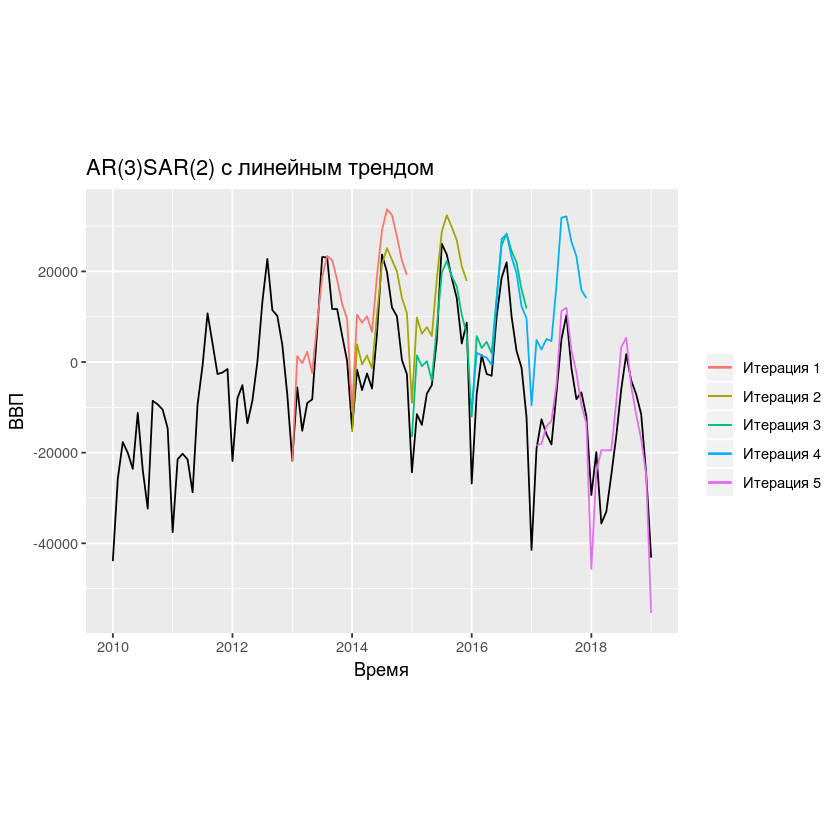

In [28]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

# for (i in 0:(var_iter*var_allornot - var_shift)){
#     k  <-  k+1
#     st_year  <-  var_start_year + i/var_allornot
#     train_start  <- st_year 
#     train_end  <- st_year + 1/var_freq*(var_window)
#     test_start  <- st_year + 1/var_freq*(var_window+1) 
#     test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1

    

for (i in 1:length(l)){
    if (i!=length(l)){
    plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1), series=paste("Итерация" , i, sep=" ") ) 
    }else{
            plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1-var_topup/var_freq), series=paste("Итерация" , i, sep=" ") ) 

        
    }
}

plot_forecasts


In [29]:
colMeans(df_acc)

ME       RMSE       MAPE  Iteration 
-9094.4333 12131.1773   263.8979    25.2000

In [30]:
# df_mean_acc <- readRDS("df_mean_acc.rds")
# rownames(df_mean_acc)[2:5]  <-  c('3 level', '2 level (state)', '2 level (type)' ,'2 level (clusetered)' )

In [31]:
df_mean_acc[3,3]  <-  colMeans(df_acc)[[2]] 
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,82.46349,320.0250,12274.00
3 level,83.34961,319.6023,12126.13
2 level (state),82.52303,319.5933,12131.18
2 level (type),81.81728,321.0356,NA
2 level (clusetered),82.25295,317.7805,NA


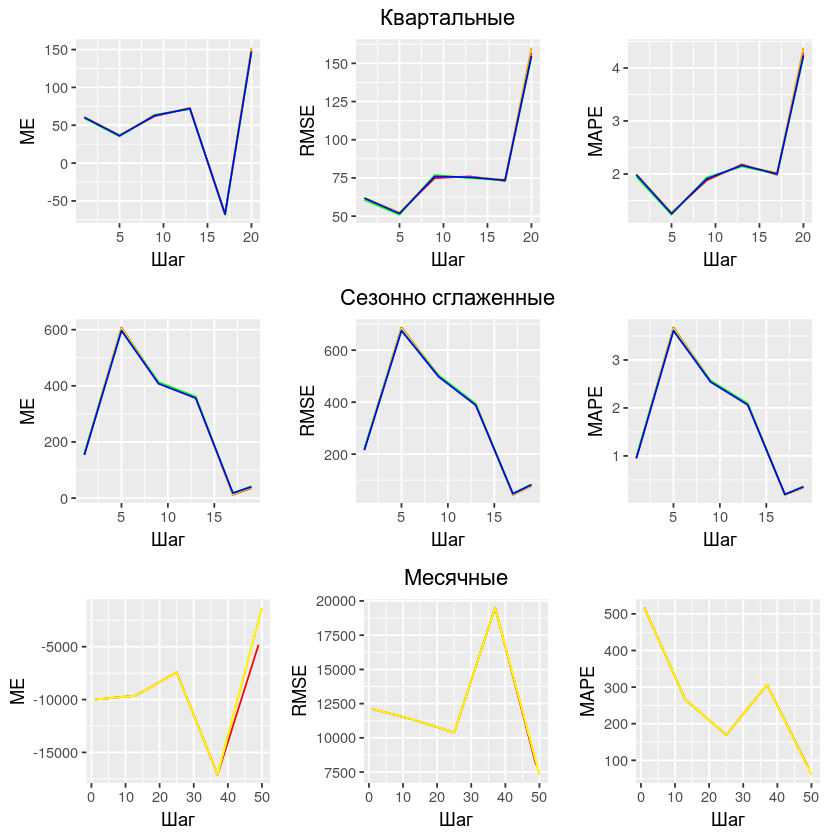

In [32]:
# Basic line plot with points

# plots_test_all <- readRDS("plots_test_not_all.rds")

var_col_test  <-  'yellow'
# var_col_train  <-  'red'

for (i in 1:3) {
    
    k = i + 6
    
    if  (i==1) {
        
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=ME), colour = var_col_test, data =  df_acc) 
    
        } else if (i==2) { 
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=RMSE), colour = var_col_test, data =  df_acc) 
        } else if (i==3)  {
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=MAPE), colour = var_col_test, data =  df_acc) 
 
    }        
    }

grid.arrange(grobs = plots_test_all, ncol = 3)

#### 2 type

In [33]:
df_eu  <-  read.csv(file="../clustering/hts_rus_summed_type.csv", header=TRUE, sep=",", row.names =1 )
# df_eu  <-  df_eu/1000


In [34]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

In [35]:
df_eu  <-  as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data)
s  <-  smatrix(y)
# gts_train  <- window(y, start=20, end=67)
# gts_test  <- window(y, start=68, end=75)
allts <- aggts(y)
allf <- matrix(, nrow=var_h, ncol=ncol(allts))

Since argument characters are not specified, the default labelling system is used.


In [36]:
l <- ac <- m_top  <- l_test  <-  l_top  <-  list()

df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1
    
    train_start  <- dates[1] 
    train_end  <- dates[2]
    test_start  <- dates[3]
    test_end  <- dates[4]
    
    print(c(train_start, train_end, test_start, test_end))
    
    
    if (i == 0){
        gts_train <- window(y, end=train_end)    
    }
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            gts_train <- window(y, start=dates[5], end=dates[6])
        }else{
            gts_train <- window(y, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        gts_test <- window(y, start=dates[7])
      
    }else{  
     gts_test <- window(y, start=test_start, end=test_end)
          
    }
    
    allts <- aggts(gts_train)
    
    ms <-  foreach(j=1:ncol(allts)) %dopar% {
        model  <- tryCatch(        
        Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq,  include.drift = var_drift, include.mean = var_constant, method="ML"), 
            error = function(e) 
#                               {tryCatch( 
                Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq, include.drift = var_drift, include.mean = var_constant, method="CSS") #,
#                          error = function(e)              
#                             auto.arima(msts(allts[,j], seasonal.periods = var_freq))
#                          )}
                        
            )
        
    }
    
     
        
    allf <- matrix(, nrow=var_h, ncol=ncol(allts))
        
    
    for(j in 1:ncol(allts)){  
    allf[,j] <- forecast(ms[[j]], h=var_h)$mean
    
    
    }

    
    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g)
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5)
        
#     if (i == 4){
#         gts_forecasts_7 <- window(y_f5, start=test_start)}
#     else{
#     gts_forecasts_7 <- window(y_f5, start=test_start, end=test_end)
# #     }

#     if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
#         gts_forecasts_7 <- window(y_f5, start=dates[7])
      
#     }else{  
     gts_forecasts_7 <- window(y_f5, start=dim(y_f5[[1]])[1]-var_h+1)
          
#     }
         
    print(gts_forecasts_7)
    print(gts_test)
            
    
    l[[k]]  <- allf

    ac[[k]]  <-  accuracy.gts(gts_forecasts_7, gts_test)[, 1] 

    progress(i, progress.bar = TRUE)
            
    }

[1]   1  84  85 108


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 4 
Total number of series: 5 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -20179.5950   1112.6603   -841.7378   2750.7173  -2947.0908   8655.3635
 [7]  19784.5744  23364.8926  22588.5049  18578.5917  12351.3922   9494.3575
[13] -10030.1405  10104.4733   8898.3550  10490.3292   6334.3858  19344.1811
[19]  29392.8590  33628.5312  32764.9573  27728.0369  22272.9493  19512.3055
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 4 
Total number of series: 5 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -21804  -5608 -15157  -9048  -8227   6992  23186  23066  11709  11702
[11]   5839    263 -14727  -1700  -6177  -2526  -5848   6309  23731  19854
[21]  12060  10071    438  -2700
          0%---------25%---------50%---------75%--------100%
Progress: [1]  13  96  97 120


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 4 
Total number of series: 5 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -15188.766   2813.677  -1939.080    807.311  -2162.905  10227.787
 [7]  21848.668  24536.621  21956.044  19775.738  13108.243  10121.454
[13]  -9264.287   8614.450   5235.268   6837.636   4891.555  17615.116
[19]  28244.154  31588.845  29029.629  26307.500  20160.280  17063.777
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 4 
Total number of series: 5 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 97 
End = 120 
Frequency = 1 
 [1] -14727  -1700  -6177  -2526  -5848   6309  23731  19854  12060  10071
[11]    438  -2700 -24328 -11496 -13858  -6986  -5066   4880  26123  23705
[21]  18556  14103   4114   8705
[1]  25 108 109 132


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 4 
Total number of series: 5 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -16979.251   1100.181  -1378.101    114.462  -3696.428   8258.890
 [7]  20297.226  22430.010  19523.645  16561.708  10245.207   6493.422
[13] -12347.733   5926.783   3317.989   4387.498   2479.090  14630.502
[19]  25980.991  28755.443  24975.259  22029.953  16339.549  12131.947
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 4 
Total number of series: 5 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 109 
End = 132 
Frequency = 1 
 [1] -24328 -11496 -13858  -6986  -5066   4880  26123  23705  18556  14103
[11]   4114   8705 -26799  -6998   1542  -2629  -3031  10067  18591  22017
[21]  10026   2420  -1256 -12220
|[1]  37 120 121 144


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 4 
Total number of series: 5 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -12167.6053   1240.3655    931.9680    285.1740   -934.2465  13236.0561
 [7]  26255.6229  27446.0784  23164.8783  18736.4280  11889.7149   9651.7598
[13] -10487.5904   4885.8295   2894.9670   4682.2847   4465.7187  16815.3029
[19]  30860.2427  31566.1327  26517.1743  22855.8482  15812.3584  13864.7260
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 4 
Total number of series: 5 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 121 
End = 144 
Frequency = 1 
 [1] -26799  -6998   1542  -2629  -3031  10067  18591  22017  10026   2420
[11]  -1256 -12220 -41475 -19176 -12642 -15942 -18179  -6838   5045  10369
[21]  -1320  -8177  -6696 -12005
|[1]  49 132 133 156


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 4 
Total number of series: 5 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -17282.457 -17767.789 -13429.350 -12001.252  -4806.971  11666.820
 [7]  12081.830   1983.848  -1185.469  -8969.562 -14021.848 -43681.796
[13] -23140.897 -19481.765 -17920.448 -18839.785  -8325.350   4508.838
[19]   5142.994  -4396.505  -9188.418 -15712.644 -22724.351 -51611.801
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 4 
Total number of series: 5 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 134 
End = 157 
Frequency = 1 
 [1] -19176 -12642 -15942 -18179  -6838   5045  10369  -1320  -8177  -6696
[11] -12005 -29346 -19876 -35619 -33053 -24949 -16354  -5987   1730  -4072
[21]  -7117 -11516 -24655 -43180


In [37]:
var_acc_metrics  <-  c(1,2,4)
df_acc_test  <- ac[[1]][var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc  <- df_acc_test
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [38]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [39]:
df_acc

ME,RMSE,MAPE,Iteration
-10143.994,12138.72,515.74718,1
-8957.988,10649.89,244.68131,13
-7558.177,10422.90,172.09597,25
-16657.300,19139.06,299.96930,37
-2102.120,7130.57,56.98335,50


In [40]:
l[[5]][,1]

Time Series:
Start = 1 
End = 24 
Frequency = 1 
 [1] -18465.263 -18013.514 -14147.644 -13017.856  -4875.290  11253.794
 [7]  11989.259   2601.752  -2270.057  -9506.055 -13473.768 -45650.058
[13] -24242.214 -19453.504 -19475.942 -19469.850  -8805.389   3293.581
[19]   5363.691  -5384.058 -11649.020 -17031.936 -24837.424 -55395.973

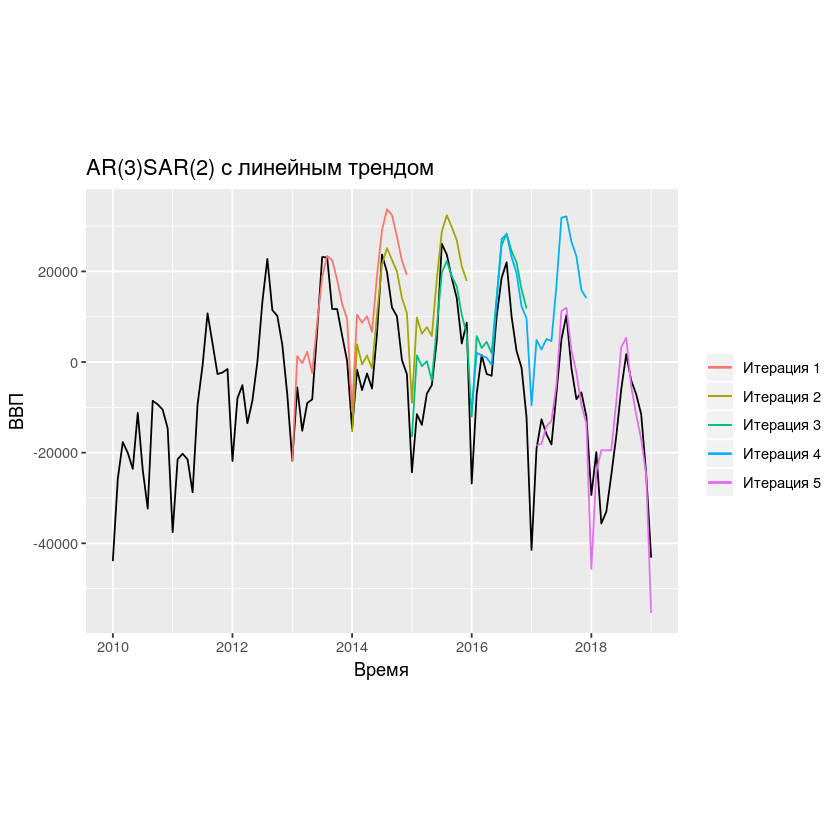

In [41]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

# for (i in 0:(var_iter*var_allornot - var_shift)){
#     k  <-  k+1
#     st_year  <-  var_start_year + i/var_allornot
#     train_start  <- st_year 
#     train_end  <- st_year + 1/var_freq*(var_window)
#     test_start  <- st_year + 1/var_freq*(var_window+1) 
#     test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1

    

for (i in 1:length(l)){
    if (i!=length(l)){
    plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1), series=paste("Итерация" , i, sep=" ") ) 
    }else{
            plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1-var_topup/var_freq), series=paste("Итерация" , i, sep=" ") ) 

        
    }
}

plot_forecasts


In [42]:
colMeans(df_acc)

ME       RMSE       MAPE  Iteration 
-9083.9156 11896.2272   257.8954    25.2000

In [43]:
# df_mean_acc <- readRDS("df_mean_acc.rds")
# rownames(df_mean_acc)[2:5]  <-  c('3 level', '2 level (state)', '2 level (type)' ,'2 level (clusetered)' )

In [44]:
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,82.46349,320.0250,12274.00
3 level,83.34961,319.6023,12126.13
2 level (state),82.52303,319.5933,12131.18
2 level (type),81.81728,321.0356,NA
2 level (clusetered),82.25295,317.7805,NA


In [45]:
df_mean_acc[4,3]  <-  colMeans(df_acc)[[2]] 
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,82.46349,320.0250,12274.00
3 level,83.34961,319.6023,12126.13
2 level (state),82.52303,319.5933,12131.18
2 level (type),81.81728,321.0356,11896.23
2 level (clusetered),82.25295,317.7805,NA


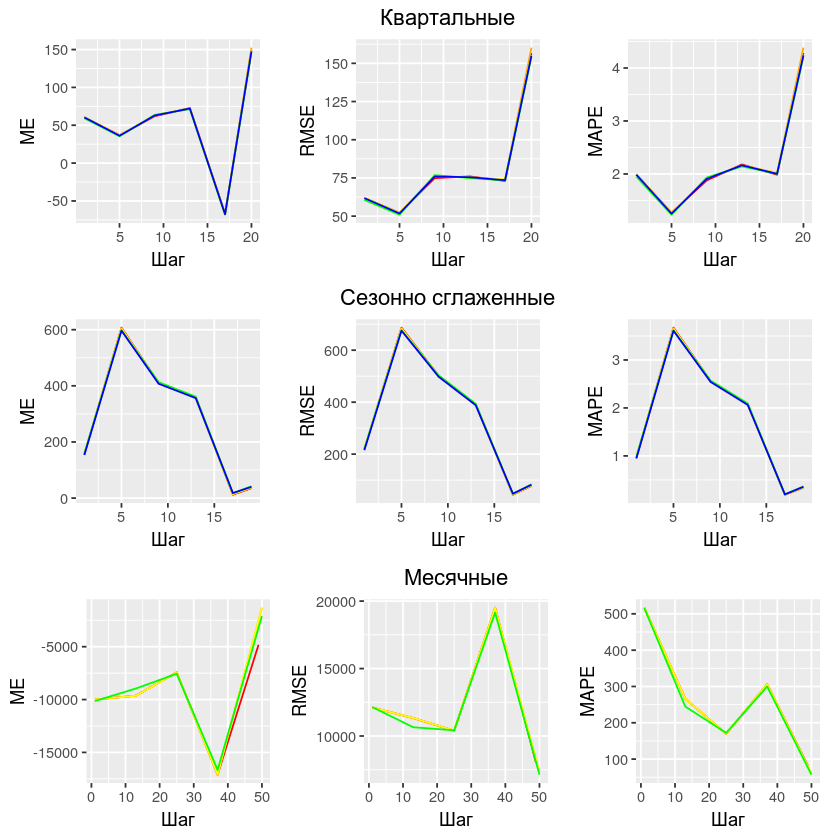

In [46]:
# Basic line plot with points

# plots_test_all <- readRDS("plots_test_not_all.rds")

var_col_test  <-  'green'
# var_col_train  <-  'red'

for (i in 1:3) {
    
    k = i + 6
    
    if  (i==1) {
        
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=ME), colour = var_col_test, data =  df_acc) 
    
        } else if (i==2) { 
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=RMSE), colour = var_col_test, data =  df_acc) 
        } else if (i==3)  {
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=MAPE), colour = var_col_test, data =  df_acc) 
 
    }        
    }

grid.arrange(grobs = plots_test_all, ncol = 3)

#### 2 clust

In [47]:
df_eu  <-  read.csv(file="../clustering/hts_rus_summed_clust.csv", header=TRUE, sep=",", row.names =1 )
# df_eu  <-  df_eu/1000


In [48]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

In [49]:
df_eu  <-  as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data)
s  <-  smatrix(y)
# gts_train  <- window(y, start=20, end=67)
# gts_test  <- window(y, start=68, end=75)
allts <- aggts(y)
allf <- matrix(, nrow=var_h, ncol=ncol(allts))

Since argument characters are not specified, the default labelling system is used.


In [50]:
l <- ac <- m_top  <- l_test  <-  l_top  <-  list()

df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1
    
    train_start  <- dates[1] 
    train_end  <- dates[2]
    test_start  <- dates[3]
    test_end  <- dates[4]
    
    print(c(train_start, train_end, test_start, test_end))
    
    
    if (i == 0){
        gts_train <- window(y, end=train_end)    
    }
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            gts_train <- window(y, start=dates[5], end=dates[6])
        }else{
            gts_train <- window(y, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        gts_test <- window(y, start=dates[7])
      
    }else{  
     gts_test <- window(y, start=test_start, end=test_end)
          
    }
    
    allts <- aggts(gts_train)
    
    ms <-  foreach(j=1:ncol(allts)) %dopar% {
        model  <- tryCatch(        
        Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq,  include.drift = var_drift, include.mean = var_constant, method="ML"), 
            error = function(e) 
#                               {tryCatch( 
                Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq, include.drift = var_drift, include.mean = var_constant, method="CSS") #,
#                          error = function(e)              
#                             auto.arima(msts(allts[,j], seasonal.periods = var_freq))
#                          )}
                        
            )
        
    }
    
     
        
    allf <- matrix(, nrow=var_h, ncol=ncol(allts))
        
    
    for(j in 1:ncol(allts)){  
    allf[,j] <- forecast(ms[[j]], h=var_h)$mean
    
    
    }

    
    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g)
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5)
        
#     if (i == 4){
#         gts_forecasts_7 <- window(y_f5, start=test_start)}
#     else{
#     gts_forecasts_7 <- window(y_f5, start=test_start, end=test_end)
# #     }

#     if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
#         gts_forecasts_7 <- window(y_f5, start=dates[7])
      
#     }else{  
     gts_forecasts_7 <- window(y_f5, start=dim(y_f5[[1]])[1]-var_h+1)
          
#     }
         
    print(gts_forecasts_7)
    print(gts_test)
            
    
    l[[k]]  <- allf

    ac[[k]]  <-  accuracy.gts(gts_forecasts_7, gts_test)[, 1] 

    progress(i, progress.bar = TRUE)
            
    }

[1]   1  84  85 108


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -21730.3890   1234.3921   -344.3426   2366.2705  -2516.2171   8803.4250
 [7]  18918.2365  23391.0430  22517.5257  18257.6603  12770.0332   9539.5631
[13] -10668.4602  10396.1893   8723.4633  10161.9028   6590.6067  19110.7060
[19]  29117.0780  33692.4648  32496.5363  27690.7165  22332.8536  19258.0919
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -21804  -5608 -15157  -9048  -8227   6992  23186  23066  11709  11702
[11]   5839    263 -14727  -1700  -6177  -2526  -5848   6309  23731  19854
[21]  12060  10071    438  -2700
          0%---------25%---------50%---------75%--------100%
Progress: [1]  13  96  97 12

Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -15437.2199   3645.7075   -827.9709   1276.0413  -1606.6404  10466.6728
 [7]  21556.5433  24954.1345  22366.6714  19888.9505  13879.0181  10550.0119
[13]  -9120.6364   9492.7534   5967.9635   7438.7138   5491.9890  18032.6571
[19]  28574.2264  32138.0435  29538.1595  26684.0590  20850.6206  17631.8345
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 97 
End = 120 
Frequency = 1 
 [1] -14727  -1700  -6177  -2526  -5848   6309  23731  19854  12060  10071
[11]    438  -2700 -24328 -11496 -13858  -6986  -5066   4880  26123  23705
[21]  18556  14103   4114   8705
[1]  25 108 109 132


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -16641.4531   1388.2838  -1001.4809    180.9989  -3990.4758   7913.1719
 [7]  19827.5895  22311.4418  19031.5211  16660.7823  10415.3512   6179.9728
[13] -12103.2322   5760.3468   3128.5762   4430.2895   2050.4130  14356.2505
[19]  25813.5944  28407.1698  24546.8984  21959.8159  16066.8594  11859.3293
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 109 
End = 132 
Frequency = 1 
 [1] -24328 -11496 -13858  -6986  -5066   4880  26123  23705  18556  14103
[11]   4114   8705 -26799  -6998   1542  -2629  -3031  10067  18591  22017
[21]  10026   2420  -1256 -12220
|[1]  37 120 121 144


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -10936.8891   1905.3395   1342.9535    824.9558   -673.1398  13306.8464
 [7]  26968.9153  28051.1254  23133.6763  19399.0641  12215.0435   9598.5527
[13]  -9773.0876   4855.5466   2745.5775   4965.7213   4566.7561  16848.4623
[19]  31650.2339  32009.5184  26509.4981  23239.0520  15831.4673  13998.7461
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 121 
End = 144 
Frequency = 1 
 [1] -26799  -6998   1542  -2629  -3031  10067  18591  22017  10026   2420
[11]  -1256 -12220 -41475 -19176 -12642 -15942 -18179  -6838   5045  10369
[21]  -1320  -8177  -6696 -12005
|[1]  49 132 133 156


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -18226.199 -17967.910 -14041.856 -12830.486  -4829.821  11346.151
 [7]  12074.745   2555.626  -2053.671  -9350.242 -13524.042 -45231.648
[13] -23969.722 -19404.828 -19179.649 -19313.486  -8669.820   3560.232
[19]   5393.806  -5134.456 -11171.711 -16718.329 -24396.128 -54636.461
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 24 
Top level series: 
Time Series:
Start = 134 
End = 157 
Frequency = 1 
 [1] -19176 -12642 -15942 -18179  -6838   5045  10369  -1320  -8177  -6696
[11] -12005 -29346 -19876 -35619 -33053 -24949 -16354  -5987   1730  -4072
[21]  -7117 -11516 -24655 -43180


In [51]:
var_acc_metrics  <-  c(1,2,4)
df_acc_test  <- ac[[1]][var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc  <- df_acc_test
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [52]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [53]:
df_acc

ME,RMSE,MAPE,Iteration
-10017.140,12109.214,516.78064,1
-9424.804,11124.713,260.30677,13
-7432.084,10383.065,169.60334,25
-16995.414,19407.103,304.34666,37
-1409.796,7262.378,59.94957,50


In [54]:
l[[5]][,1]

Time Series:
Start = 1 
End = 24 
Frequency = 1 
 [1] -18465.263 -18013.514 -14147.644 -13017.856  -4875.290  11253.794
 [7]  11989.259   2601.752  -2270.057  -9506.055 -13473.768 -45650.058
[13] -24242.214 -19453.504 -19475.942 -19469.850  -8805.389   3293.581
[19]   5363.691  -5384.058 -11649.020 -17031.936 -24837.424 -55395.973

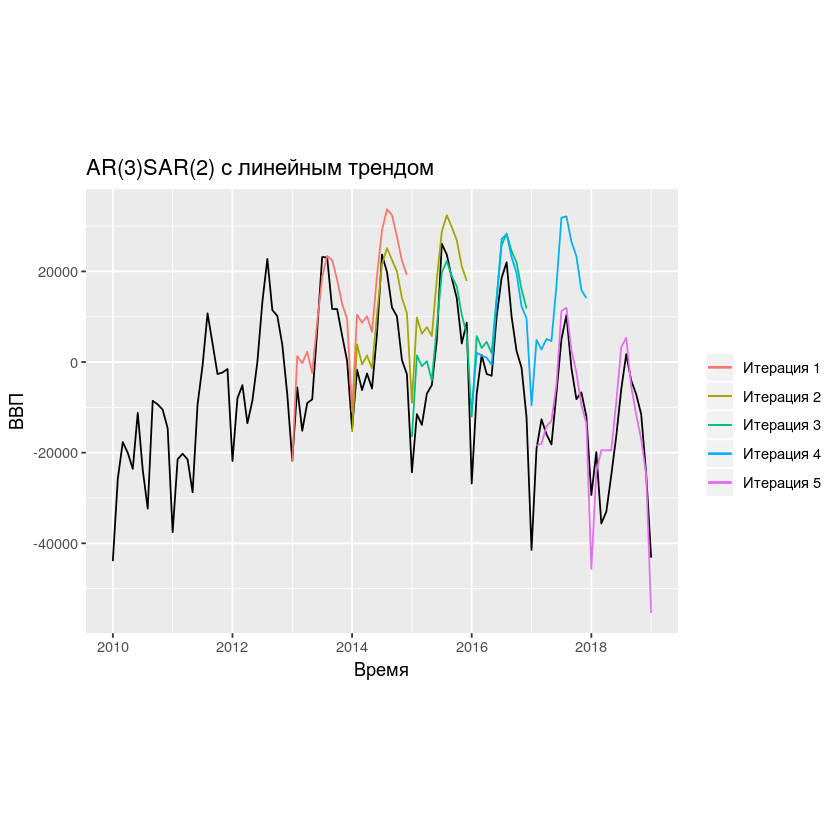

In [55]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

# for (i in 0:(var_iter*var_allornot - var_shift)){
#     k  <-  k+1
#     st_year  <-  var_start_year + i/var_allornot
#     train_start  <- st_year 
#     train_end  <- st_year + 1/var_freq*(var_window)
#     test_start  <- st_year + 1/var_freq*(var_window+1) 
#     test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1

    

for (i in 1:length(l)){
    if (i!=length(l)){
    plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1), series=paste("Итерация" , i, sep=" ") ) 
    }else{
            plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1-var_topup/var_freq), series=paste("Итерация" , i, sep=" ") ) 

        
    }
}

plot_forecasts


In [56]:
colMeans(df_acc)

ME       RMSE       MAPE  Iteration 
-9055.8475 12057.2946   262.1974    25.2000

In [57]:
# df_mean_acc <- readRDS("df_mean_acc.rds")
# rownames(df_mean_acc)[2:5]  <-  c('3 level', '2 level (state)', '2 level (type)' ,'2 level (clusetered)' )

In [58]:
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,82.46349,320.0250,12274.00
3 level,83.34961,319.6023,12126.13
2 level (state),82.52303,319.5933,12131.18
2 level (type),81.81728,321.0356,11896.23
2 level (clusetered),82.25295,317.7805,NA


In [59]:
df_mean_acc[5,3]  <-  colMeans(df_acc)[[2]] 
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,82.46349,320.0250,12274.00
3 level,83.34961,319.6023,12126.13
2 level (state),82.52303,319.5933,12131.18
2 level (type),81.81728,321.0356,11896.23
2 level (clusetered),82.25295,317.7805,12057.29


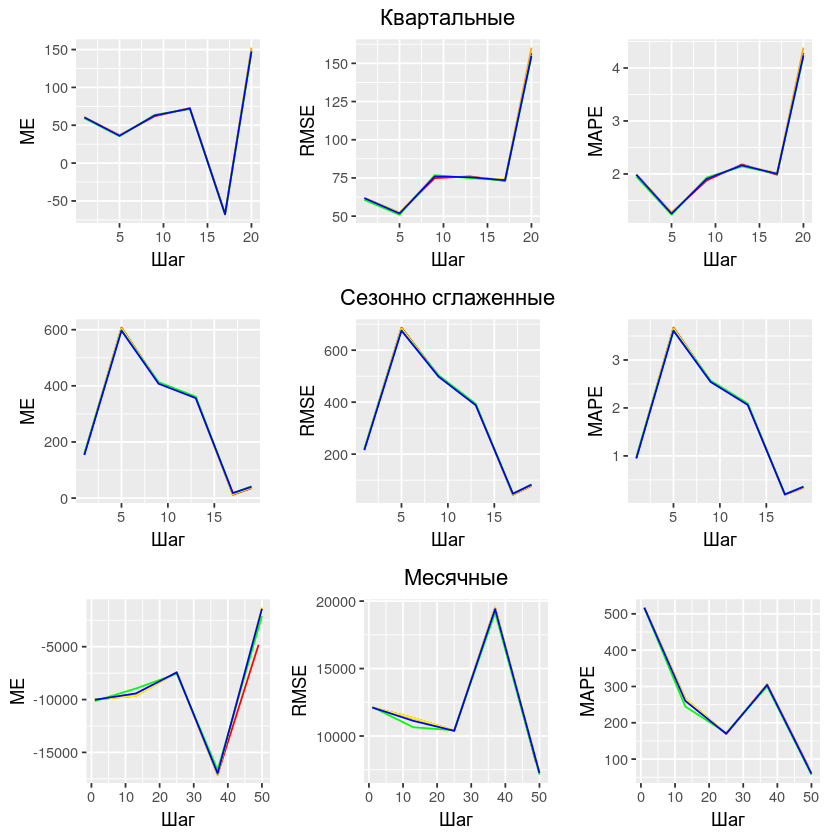

In [60]:
# Basic line plot with points

# plots_test_all <- readRDS("plots_test_not_all.rds")

var_col_test  <-  'blue'
# var_col_train  <-  'red'

for (i in 1:3) {
    
    k = i + 6
    
    if  (i==1) {
        
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=ME), colour = var_col_test, data =  df_acc) 
    
        } else if (i==2) { 
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=RMSE), colour = var_col_test, data =  df_acc) 
        } else if (i==3)  {
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=MAPE), colour = var_col_test, data =  df_acc) 
 
    }        
    }

grid.arrange(grobs = plots_test_all, ncol = 3)

In [61]:
saveRDS(df_mean_acc, "df_mean_acc.rds")
saveRDS(plots_test_all, "plots_test_not_all.rds")